# Gradient Boost Machine


## Einleitung

boosting controls both the aspects (bias & variance). It combines a set of weak learners and delivers improved prediction accuracy.

The overall parameters can be divided into 3 categories:

  -  Tree-Specific Parameters: These affect each individual tree in the model.
  -  Boosting Parameters: These affect the boosting operation in the model.
  -  Miscellaneous Parameters: Other parameters for overall functioning.
  
  
  Quelle:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [1]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.utils import shuffle

import seaborn as sns

%matplotlib inline


pd.options.display.precision = 10

## Umgebungsvariablen

In [2]:
#feature generated 24.03.2019
earthquake_daten = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/earthquake_data/'''
feature_62900_94 = 'Features_62900-94.csv'
feature_41934_94 = 'Features_41934_94.csv'
Features_4194_94 = 'Features_4194_94.csv'

# Feature laden

In [3]:
train_data = pd.read_csv(earthquake_daten+feature_41934_94)
train_data = shuffle(train_data, random_state=10)

In [4]:
feature_data = train_data.iloc[:,1:95]
time_to_failure = np.array(train_data.iloc[:,-1])

## Feature Filtern

In [22]:
items_to_filter = ['']

In [23]:
filtered_feature_data = feature_data.filter(items=items_to_filter)

In [24]:
feature_data = filtered_feature_data

# Model Workbench

## Imports

In [5]:
# Scaler


# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Quelle: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [6]:
def getMostImportendFeatuers(feat_imp, topAmount):
    '''Gibt die wichtigsten Features zurück. Wird benötigt, um die Trainingsdaten und Testdaten 
    anhand Featuers zu filtern.'''
    i = 0
    featureFilter = list()
    for feature in feat_imp:
        featureFilter.append(feature)
        i +=1
        if i >= topAmount:
            break
    return featureFilter

In [7]:
def modelfit(alg, dtrain, time_to_failure, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, time_to_failure)
      
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, time_to_failure, cv=cv_folds, scoring='neg_mean_absolute_error',n_jobs=-1)
    
    #Print model report:
    print("\nModel Report")
    print("MAE train data: %.4g" % mean_absolute_error(time_to_failure, dtrain_predictions)) 
    
    if performCV:
        print("CV Score MAE: \nMean %.7g \nStd %.7g \nMin %.7g \nMax %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances',figsize=(15,10))
        plt.ylabel('Feature Importance Score')
        plt.show()
        print('Top 20 Feature')
        print(getMostImportendFeatuers(feat_imp.index,20))

In [12]:
def test_Model_with_62900_test_train_split(model,feature_filter= ['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max']):
    #load Features_62900
    train_data = pd.read_csv(earthquake_daten+feature_62900_94)
    train_data = shuffle(train_data, random_state=10)
    feature_data = train_data.iloc[:,1:95]
    time_to_failure = np.array(train_data.iloc[:,-1])

    filtered_feature = feature_data.filter(items=feature_filter)   

    X_train, X_test, y_train, y_test = train_test_split(filtered_feature, time_to_failure, test_size=0.20, random_state=42,shuffle=True)
    
    #fit model
    model.fit(X_train,y_train)
    
    #predict
    prediction = model.predict(X_test)
    
    print("MAE train / test data: %.4g" % mean_absolute_error(y_test, prediction)) 

In [14]:
def test_Model_with_41934_test_train_split_Best_20(model,feature_filter = ['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max']):
    train_data = pd.read_csv(earthquake_daten+feature_41934_94)
    train_data = shuffle(train_data, random_state=10)
    feature_data = train_data.iloc[:,1:95]
    time_to_failure = np.array(train_data.iloc[:,-1])

    filtered_feature = feature_data.filter(items=feature_filter)   

    X_train, X_test, y_train, y_test = train_test_split(filtered_feature, time_to_failure, test_size=0.20, random_state=42,shuffle=True)
    
    #fit model
    model.fit(X_train,y_train)
    
    #predict
    prediction = model.predict(X_test)
    
    print("MAE train / test data: %.4g" % mean_absolute_error(y_test, prediction)) 

# Baseline 94 Features / 41934 rows


Model Report
MAE train data: 1.962
CV Score MAE: 
Mean -1.990055 
Std 0.006864405 
Min -1.999474 
Max -1.979146


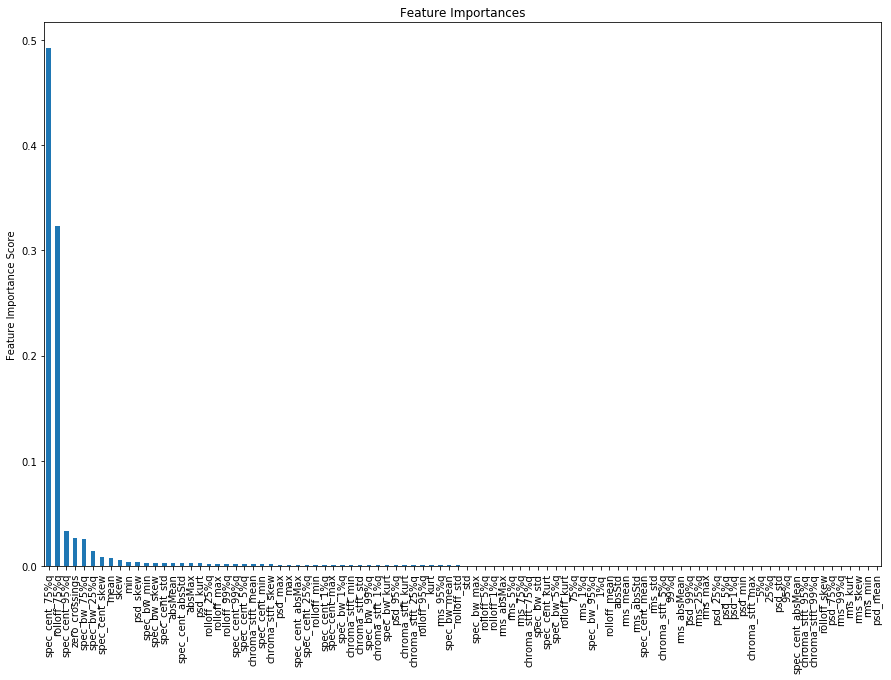

Top 20 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max']


In [9]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, feature_data, time_to_failure)

# Model with 20 Features

## Filter Feature
Anhand Feature importence (

In [11]:
items_to_filter = ['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max']
filtered_feature_data = feature_data.filter(items=items_to_filter)  


Model Report
MAE train data: 1.966
CV Score MAE: 
Mean -1.990398 
Std 0.006181515 
Min -1.998332 
Max -1.983396


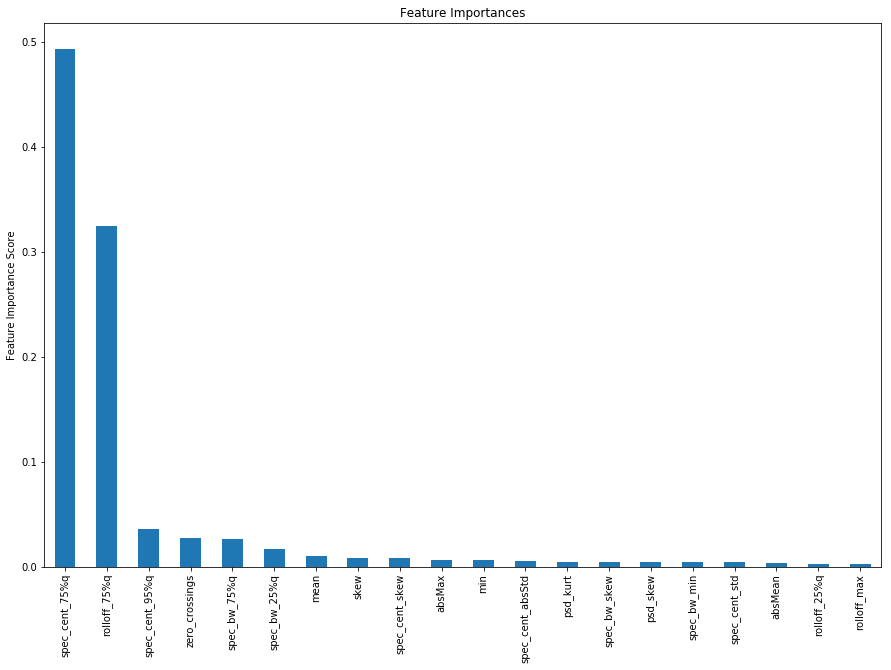

Top 20 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'mean', 'skew', 'spec_cent_skew', 'absMax', 'min', 'spec_cent_absStd', 'psd_kurt', 'spec_bw_skew', 'psd_skew', 'spec_bw_min', 'spec_cent_std', 'absMean', 'rolloff_25%q', 'rolloff_max']


In [10]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, filtered_feature_data, time_to_failure)

In [15]:
gbm0 = GradientBoostingRegressor(random_state=10)
test_Model_with_41934_test_train_split_Best_20(gbm0)

MAE train / test data: 1.988


## Feature Analyse

In [11]:
filtered_feature_data.describe()

,spec_cent_75%q,rolloff_75%q,spec_cent_95%q,zero_crossings,spec_bw_75%q,spec_bw_25%q,spec_cent_skew,mean,skew,min,psd_skew,spec_bw_min,spec_bw_skew,spec_cent_std,absMean,spec_cent_absStd,absMax,psd_kurt,rolloff_25%q,rolloff_max
count,41934.0000000000,4.1934000000e+04,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,4.1934000000e+04,4.1934000000e+04
mean,742387.2523088438,1.4689638778e+06,766501.4226891467,12364.2003386274,578274.0256393899,557027.9247439427,-1.7684765868,4.5194207052,0.1252057914,-149.3662421901,4.3532761010,369580.5488563732,-3.1091462491,84680.0669979103,5.5475340882,84680.0669979103,170.2135260171,21.3592964286,1.3654761519e+06,1.5279052257e+06
std,20776.6077719682,2.0638896524e+04,12738.7647896970,2350.7020123311,3704.6218152966,15881.1905858769,0.6537748001,0.2561034062,0.4860815241,266.0096389602,0.6992302210,61468.9499724829,0.9061073529,17685.2075445529,1.5159142190,17685.2075445529,297.8494453362,7.5717075103,7.7640648481e+04,1.3003077356e+04
min,539282.7949792275,1.1894531250e+06,647020.8741038998,5124.0000000000,517037.1742718818,359230.6531110291,-6.3139636437,3.5550933333,-5.5187945968,-5515.0000000000,1.8558664322,113489.2027425448,-8.7072632508,24103.5421957797,4.1009866667,24103.5421957797,23.0000000000,3.9797691222,4.5117187500e+05,1.4453125000e+06
25%,728775.4999623451,1.4550781250e+06,757997.6752581031,10627.0000000000,576065.4411271894,549252.2569360731,-2.1248839140,4.3517900000,-0.0386432786,-155.0000000000,3.8615123630,333638.5920621625,-3.5548990084,73311.8920516433,5.0598266667,73311.8920516433,93.0000000000,15.8853275321,1.3242187500e+06,1.5195312500e+06
50%,742654.9275670950,1.4687500000e+06,766364.8596778678,12508.0000000000,578318.5132638491,558842.0486257107,-1.5966534869,4.5227633333,0.0862328996,-110.0000000000,4.2880156040,371274.4264139568,-2.9292740624,86503.1387702648,5.3774700000,86503.1387702648,127.0000000000,20.3492070936,1.3671875000e+06,1.5273437500e+06
75%,758660.7690201603,1.4843750000e+06,775932.4720382815,14132.0000000000,580908.6034652712,568587.5202436801,-1.2990743945,4.6929233333,0.2564331411,-79.0000000000,4.7566037178,410187.1897359705,-2.4763579426,96847.1908938453,5.7577166667,96847.1908938453,175.0000000000,25.4352391253,1.4218750000e+06,1.5371093750e+06
max,787634.4965454257,1.5097656250e+06,801471.0921077820,19956.0000000000,586966.0075451231,578136.8393907149,0.1351299478,5.4638133333,10.5922843032,-15.0000000000,7.9966616631,552562.8899506893,-0.7233254603,179844.2450618852,33.4719600000,179844.2450618852,5515.0000000000,70.4963456266,1.4765625000e+06,1.5878906250e+06


### Verteilung der einzelnen Features

Text(0.5, 0.98, 'Feature Histogramm')

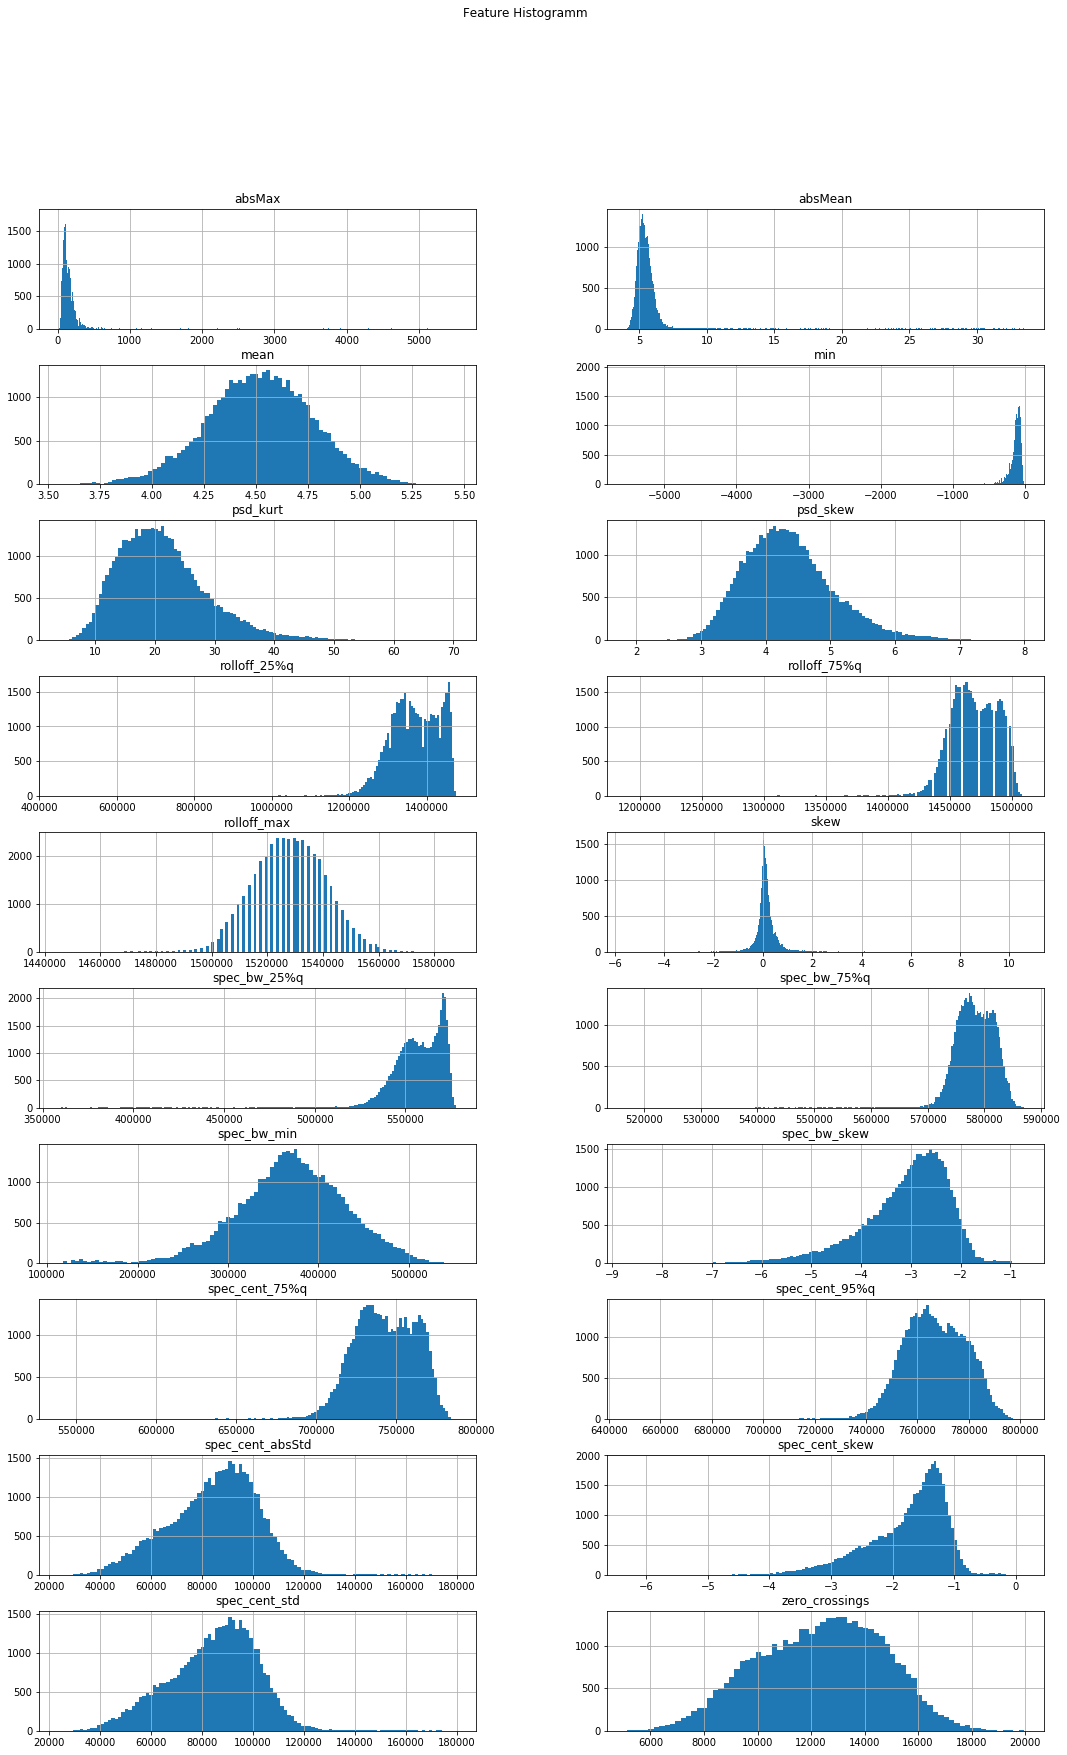

In [12]:
axes = filtered_feature_data.hist(bins='auto', figsize=(18, 28), layout=(10, 2))
plt.suptitle("Feature Histogramm")

### Korrelationen zwischen den Features

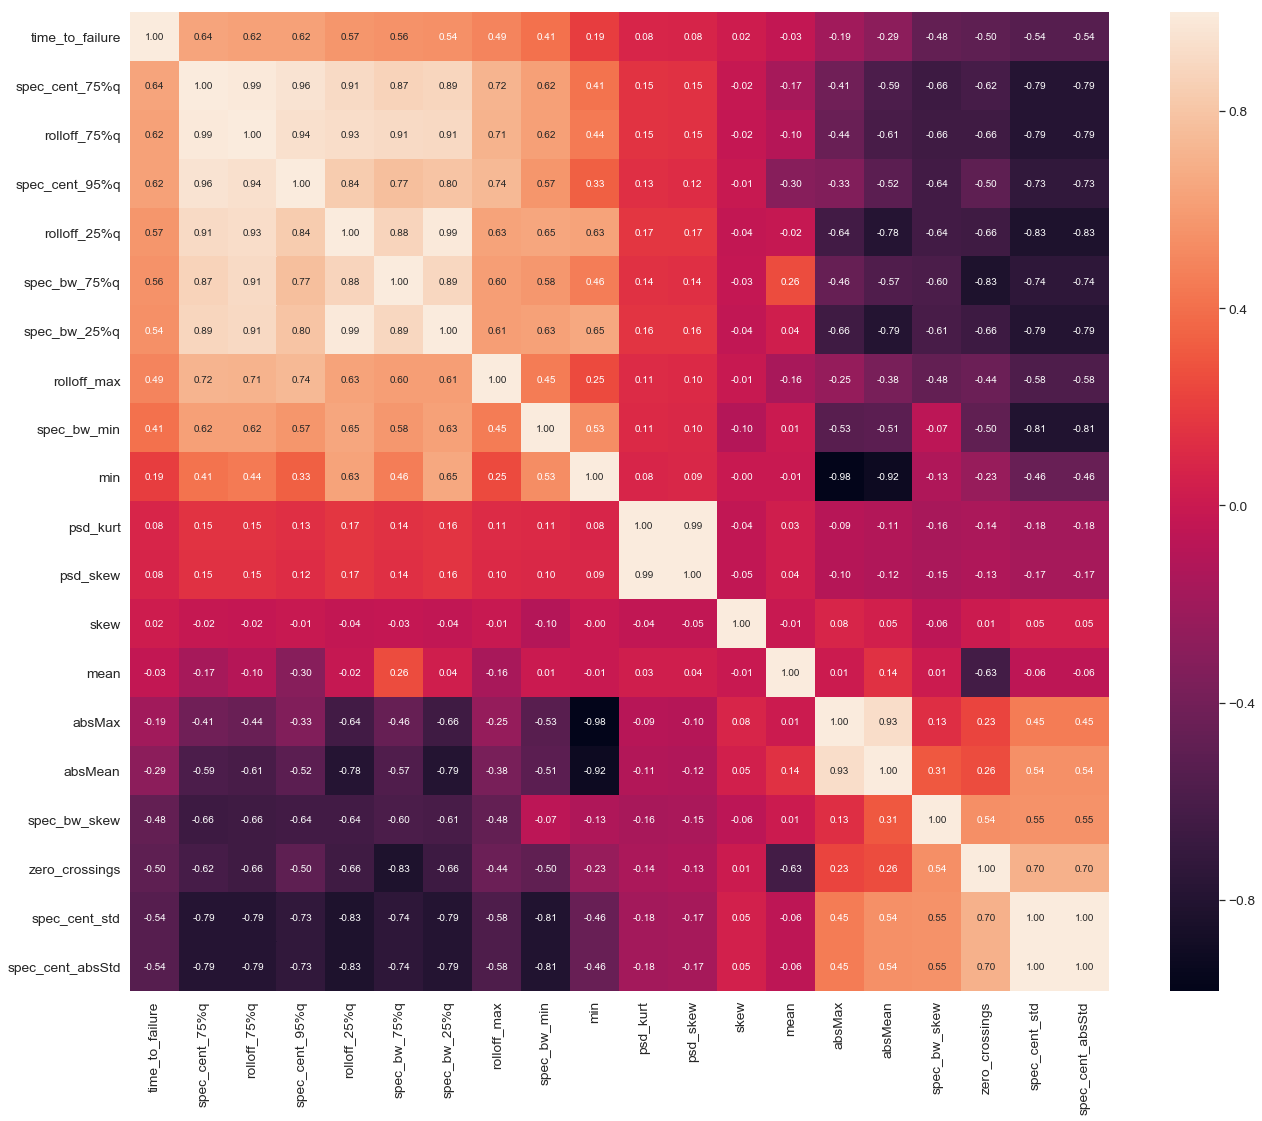

In [9]:
filtered_feature_data_corr = filtered_feature_data
filtered_feature_data_corr['time_to_failure'] = time_to_failure
corr = filtered_feature_data_corr.corr()

k = 20
plt.subplots(figsize=(22,18))
cols = corr.nlargest(k, 'time_to_failure')['time_to_failure'].index
cm = np.corrcoef(filtered_feature_data_corr[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Parameter Tuning 20 Features 4194 rows

In [16]:
train_data = pd.read_csv(earthquake_daten+Features_4194_94)
train_data = shuffle(train_data, random_state=10)


feature_data = train_data.iloc[:,1:95]
time_to_failure_tuning = np.array(train_data.iloc[:,-1])
# Erhalten aus dem Notebook Model_CatBoost_94
items_to_filter = ['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max']
filtered_feature_data_tuning = feature_data.filter(items=items_to_filter) 

## Baseline 20 Features 4194 rows

In [17]:
gbm0 = GradientBoostingRegressor(random_state=10, verbose = False)
modelfit(gbm0, filtered_feature_data_tuning, time_to_failure_tuning,printFeatureImportance=False)


Model Report
MAE train data: 1.868
CV Score MAE: 
Mean -2.072287 
Std 0.06819201 
Min -2.170945 
Max -1.981071


 Tune tree based and boosting parameters

## Tree based parameter

Fix learning rate and number of estimators for tuning tree-based parameters

### Determine the optimum number of trees and learning rate arround to tune tree based parameter

In [21]:
param_test1 = {'n_estimators':range(40,121,10)}

Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
subsample = 0.8 : This is a commonly used used start value

In [22]:
min_samples_split = int(feature_data.shape[0]*0.008)

estimator = GradientBoostingRegressor(
            learning_rate=0.1, 
            min_samples_split=500,
            min_samples_leaf=50,
            max_depth=8,
            max_features='sqrt',
            subsample=0.8,
            random_state=10)

gsearch1 = GridSearchCV(
    estimator = estimator,
    param_grid = param_test1, 
    scoring='neg_mean_absolute_error',
    iid=False,
    n_jobs=-1,
    cv=5)
                        
gsearch1.fit(filtered_feature_data_tuning,time_to_failure_tuning)

print('Best params {}'.format(gsearch1.best_params_))
print('Best MAE score: {}'.format(gsearch1.best_score_))

Best params {'n_estimators': 60}
Best MAE score: -2.0543926810238062


learning-rate verringern, damit die Anzahl Bäume steigt

### Tuning tree-specific parameters

In [23]:
n_estimators = 60
learning_rate = 0.1

### Tune max_depth and num_samples_split

In [25]:
param_test2 = {'max_depth':range(2,16,2), 'min_samples_split':range(2,12,1)}

gsearch2 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_features='sqrt', 
        subsample=0.8, 
        random_state=10), 
    param_grid = param_test2, 
    scoring='neg_mean_absolute_error',
    iid=False,
    n_jobs=-1,
    cv=5)
gsearch2.fit(filtered_feature_data_tuning,time_to_failure_tuning)
print('Best params {}'.format(gsearch2.best_params_))
print('Best MAE score: {}'.format(gsearch2.best_score_))

Best params {'max_depth': 4, 'min_samples_split': 11}
Best MAE score: -2.065517784084633


In [26]:
max_depth = 4
min_samples_split = 11

Tune min_samples_leaf

In [28]:
param_test3 = {'min_samples_leaf':range(10,80,10)}
gsearch3 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate, 
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features='sqrt', 
                            subsample=0.8, 
                            random_state=10), 
                            param_grid = 
                            param_test3,
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch3.fit(filtered_feature_data_tuning,time_to_failure_tuning)
print('Best params {}'.format(gsearch3.best_params_))
print('Best MAE score: {}'.format(gsearch3.best_score_))

Best params {'min_samples_leaf': 40}
Best MAE score: -2.059165059399919


In [29]:
min_samples_leaf=40

Jetzt werden mehrere Varibeln für die Entscheidung berücksichtigt!

Tune max_features

In [30]:
param_test4 = {'max_features':range(10,30,2)}
gsearch4 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate, 
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            subsample=0.8,
                            random_state=10),
                            param_grid = param_test4, 
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch4.fit(feature_data,time_to_failure_tuning)
print('Best params {}'.format(gsearch4.best_params_))
print('Best MAE score: {}'.format(gsearch4.best_score_))

Best params {'max_features': 16}
Best MAE score: -2.066610935761202


In [31]:
max_features = 16

 Take the variables with a higher impact on outcome first
  - Tune max_depth and num_samples_split
  - Tune min_samples_leaf
  - Tune max_features

### Tuning subsample

In [32]:
param_test5 = {'subsample':[0.65,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            random_state=10,
                            max_features=max_features),
                            param_grid = param_test5,
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch5.fit(feature_data,time_to_failure_tuning)
print('Best params {}'.format(gsearch5.best_params_))
print('Best MAE score: {}'.format(gsearch5.best_score_))

Best params {'subsample': 0.8}
Best MAE score: -2.066610935761202


In [33]:
subsample = 0.8

### Tune learning_rate and n_estimators

In [48]:
param_test6 = {'learning_rate':[0.09,0.08, 0.07],'n_estimators' :[50]}
gsearch6 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(
                            criterion='mae',
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            subsample=subsample,
                            random_state=10),
                        param_grid = param_test6,
                        scoring='neg_mean_absolute_error',
                        iid=False,
                        n_jobs=-1,
                        cv=5)

gsearch6.fit(feature_data,time_to_failure_tuning)
print('Best params {}'.format(gsearch6.best_params_))
print('Best MAE score: {}'.format(gsearch6.best_score_))

Best params {'learning_rate': 0.08, 'n_estimators': 50}
Best MAE score: -2.040172457952127


In [49]:
learning_rate = 0.08
n_estimators = 50

### Tuned model with 20 Features / 4194 rows

In [50]:
model = GradientBoostingRegressor(criterion='mae',
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            random_state=10)
print(model)
                              
                              
modelfit(model,  filtered_feature_data_tuning, time_to_failure_tuning,printFeatureImportance=False)

GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=16,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=40,
             min_samples_split=11, min_weight_fraction_leaf=0.0,
             n_estimators=50, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Model Report
MAE train data: 1.824
CV Score MAE: 
Mean -2.033888 
Std 0.06087941 
Min -2.12581 
Max -1.960044


In [9]:
gra =GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=16,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=40,
             min_samples_split=11, min_weight_fraction_leaf=0.0,
             n_estimators=50, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
test_Model_with_62900_test_train_split(gra)

KeyboardInterrupt: 

# Validate (crossvalidation) tuned Model with 41934 rows

In [8]:
train_data = pd.read_csv(earthquake_daten+feature_41934_94)
train_data = shuffle(train_data, random_state=10)

feature_data = train_data.iloc[:,1:95]
time_to_failure_validation = np.array(train_data.iloc[:,-1])

items_to_filter = ['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max']
filtered_feature_data_validation = feature_data.filter(items=items_to_filter)

In [9]:
model = GradientBoostingRegressor(
                                  learning_rate=0.08, 
                                  loss='ls', 
                                  max_depth=4, 
                                  max_features=16,
                                  min_samples_leaf=40,
                                  min_samples_split=11,
                                  n_estimators=50,
                                  random_state=10,
                                  subsample=0.8)

modelfit(model,  filtered_feature_data_validation, time_to_failure_validation,printFeatureImportance=False)


Model Report
MAE train data: 1.977
CV Score MAE: 
Mean -1.999948 
Std 0.00858398 
Min -2.011527 
Max -1.990908
